# How to stream from the final node

One common pattern for graphs is to stream LLM tokens from inside the final node only. This guide demonstrates how you can do this.

## Define model and tools

First, set up a chat model and a tool to call within your graph:

```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core
```

In [1]:
import { z } from "zod";
import { tool } from "@langchain/core/tools";
import { ChatAnthropic } from "@langchain/anthropic";

const getWeather = tool(async ({ city }) => {
  if (city === "nyc") {
    return "It might be cloudy in nyc";
  } else if (city === "sf") {
    return "It's always sunny in sf";
  } else {
    throw new Error("Unknown city.");
  }
}, {
  name: "get_weather",
  schema: z.object({
    city: z.enum(["nyc", "sf"]),
  }),
  description: "Use this to get weather information",
});

const tools = [getWeather];

const model = new ChatAnthropic({
  model: "claude-3-5-sonnet-20240620",
}).bindTools(tools);


// We add a tag that we'll be using later to filter outputs
const finalModel = new ChatAnthropic({
  model: "claude-3-5-sonnet-20240620",
}).withConfig({
  tags: ["final_node"],
});

## Define graph

Now, lay out your graph:

In [2]:
import { StateGraph, MessagesAnnotation } from "@langchain/langgraph";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { AIMessage, HumanMessage, SystemMessage } from "@langchain/core/messages";

const shouldContinue = async (state: typeof MessagesAnnotation.State) => {
  const messages = state.messages;
  const lastMessage: AIMessage = messages[messages.length - 1];
  // If the LLM makes a tool call, then we route to the "tools" node
  if (lastMessage.tool_calls?.length) {
    return "tools";
  }
  // Otherwise, we stop (reply to the user)
  return "final";
};

const callModel = async (state: typeof MessagesAnnotation.State) => {
  const messages = state.messages;
  const response = await model.invoke(messages);
  // We return a list, because this will get added to the existing list
  return { messages: [response] };
};

const callFinalModel = async (state: typeof MessagesAnnotation.State) => {
  const messages = state.messages;
  const lastAIMessage = messages[messages.length - 1];
  const response = await finalModel.invoke([
    new SystemMessage("Rewrite this in the voice of Al Roker"),
    new HumanMessage({ content: lastAIMessage.content })
  ]);
  // MessagesAnnotation allows you to overwrite messages from the agent
  // by returning a message with the same id
  response.id = lastAIMessage.id;
  return { messages: [response] };
}

const toolNode = new ToolNode<typeof MessagesAnnotation.State>(tools);

const graph = new StateGraph(MessagesAnnotation)
  .addNode("agent", callModel)
  .addNode("tools", toolNode)
  // add a separate final node
  .addNode("final", callFinalModel)
  .addEdge("__start__", "agent")
  // Third parameter is optional and only here to draw a diagram of the graph
  .addConditionalEdges("agent", shouldContinue, {
    tools: "tools",
    final: "final",
  })
  .addEdge("tools", "agent")
  .addEdge("final", "__end__")
  .compile();

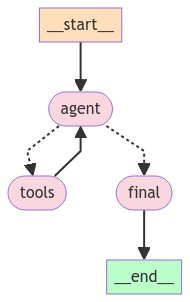

In [3]:
import * as tslab from "tslab";

const diagram = graph.getGraph();
const image = await diagram.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

tslab.display.png(new Uint8Array(arrayBuffer));

## Stream outputs from the final node

In [4]:
const inputs = { messages: [new HumanMessage("What's the weather in nyc?")] };

const eventStream = await graph.streamEvents(inputs, { version: "v2"});

for await (const { event, tags, data } of eventStream) {
  if (event === "on_chat_model_stream" && tags.includes("final_node")) {
    if (data.chunk.content) {
      // Empty content in the context of OpenAI or Anthropic usually means
      // that the model is asking for a tool to be invoked.
      // So we only print non-empty content
      console.log(data.chunk.content, "|");
    }
  }
}


Hey |
 there, folks |
! Al |
 Roker here with |
 your weather update. |


Well |
, well |
, well, it seems |
 like |
 the |
 Big |
 Apple might |
 be getting |
 a little over |
cast today. That |
's right |
, we |
're |
 looking |
 at some |
 cloud cover moving in over |
 New |
 York City. But hey |
, don't let that |
 dampen your spirits! |
 A |
 little clou |
d never |
 hurt anybody |
, |
 right?

Now |
, I |
' |
d love |
 to give |
 you more |
 details, |
 but Mother |
 Nature can |
 be as |
 unpredictable as |
 a game |
 of chance sometimes |
. So |
, if |
 you want |
 the full |
 scoop on NYC |
's weather |
 or |
 if |
 you're |
 curious |
 about conditions |
 in any other city across |
 this |
 great nation of ours |
, just give |
 me a ho |
ller! I'm here |
 to keep |
 you in the know, |
 whether |
 it's sunshine |
, |
 rain, or anything |
 in between.

Remember |
, a clou |
dy day is |
 just |
 the |
 sun |
's |
 way of letting |
 you know it's still |
 there, even if you |
 ca